## 1. Setup and Configuration

In [22]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

# SentenceTransformers and evaluation imports
from sentence_transformers import SentenceTransformer, evaluation
import torch

# Sklearn metrics
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    f1_score,
    precision_score,
    recall_score
)
from scipy.stats import spearmanr, pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Imports complete")

✓ Imports complete


In [23]:
# Auto-detect GPU and configure batch size
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

if device == 'cuda':
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {gpu_memory:.2f} GB")
    
    # Auto-configure batch size based on available memory
    if gpu_memory >= 24:
        BATCH_SIZE = 128
    elif gpu_memory >= 16:
        BATCH_SIZE = 96
    elif gpu_memory >= 12:
        BATCH_SIZE = 64
    elif gpu_memory >= 8:
        BATCH_SIZE = 48
    elif gpu_memory >= 6:
        BATCH_SIZE = 32
    else:
        BATCH_SIZE = 16
    
    print(f"Auto-configured batch size: {BATCH_SIZE}")
else:
    BATCH_SIZE = 16  # Conservative for CPU
    print(f"CPU mode - using conservative batch size: {BATCH_SIZE}")

# Paths
DATA_DIR = Path('data_new')
MODELS_DIR = Path('models')
RESULTS_DIR = MODELS_DIR / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

print(f"\n✓ Configuration complete")

Device: cpu
CPU mode - using conservative batch size: 16

✓ Configuration complete


## 2. Load and Prepare Data

In [24]:
# Load ServiceNow incident data
data_path = DATA_DIR / 'SNow_incident_ticket_data.csv'
df = pd.read_csv(data_path)

print(f"Loaded {len(df)} ServiceNow incidents")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Loaded 10633 ServiceNow incidents

Columns: ['Number', 'Description', 'Opened by', 'Company', 'ITSM Department', 'Created', 'Urgency', 'Impact', 'Priority', 'Assignment group', 'Assigned to', 'State', 'Service', 'Service offering', 'Closed', 'Closed by', 'Category', 'Subcategory', 'Resolution code', 'Resolution notes', 'User input', 'Comments and Work notes', 'Manday Effort (hrs)', 'Ticket Type', 'AMS Domain', 'AMS System Type', 'AMS Category Type', 'AMS Service Type', 'AMS Business Related', 'AMS IT Related']

First few rows:


,Number,Description,Opened by,Company,ITSM Department,Created,Urgency,Impact,Priority,Assignment group,...,User input,Comments and Work notes,Manday Effort (hrs),Ticket Type,AMS Domain,AMS System Type,AMS Category Type,AMS Service Type,AMS Business Related,AMS IT Related
0,INC0010171,GRPT not working as expected. ZMMM_PO_REV is n...,Indah Humairah Sulaiman,PIDSAP,PIDSAP,18/3/24 9:07,2 - Medium,3 - Low,4 - Low,PISCAP L2 SD BRS,...,NaN,2025-04-11 13:26:58 - BALAKUMAR GANESAN (Addit...,3.0,Issue,IS,S4HANA,Non-Genesis,Business-Related,BZ-B12-Master Data (Wrong Maintenance),NaN
1,INC0010181,eTR-S1-24000073\r\nExchange Rate did not auto ...,Indah Humairah Sulaiman,PIDSAP,PIDSAP,18/3/24 9:51,2 - Medium,3 - Low,4 - Low,PISCAP L2 Workflow (SN),...,NaN,2024-04-05 02:49:36 - Reeman Mathur (Additiona...,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN
2,INC0010188,There is no GRPT maintenance for Sold-To: 3901...,Indah Humairah Sulaiman,PIDSAP,PIDSAP,18/3/24 10:19,3 - Low,3 - Low,4 - Low,PISCAP L2 SD BRS,...,NaN,2024-05-13 12:57:15 - BALAKUMAR GANESAN (Addit...,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN
3,INC0010189,Interface\t fpl\r\nSubsidiary\t...,Chenxing Cao,PA,PISCAP,18/3/24 10:24,3 - Low,3 - Low,4 - Low,PISCAP L2 Mulesoft/SOA,...,NaN,2024-03-18 10:30:07 - Chenxing Cao (Work notes...,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN
4,INC0010192,"retrieve new SAP password, thank you.",SOOK FONG NG,PM,PM,18/3/24 10:33,1 - High,3 - Low,3 - Moderate,PISCAP L2 SAP BASIS,...,NaN,NaN,NaN,Issue,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Combine relevant text fields for complete context
def create_combined_text(row):
    """Combine available text fields with proper handling of NaN"""
    # Check what columns are available and combine them
    text_parts = []
    
    # Try different column names that might contain useful text
    for col in ['Number', 'Description', 'User input', 'Resolution notes']:
        if col in row.index:
            value = str(row.get(col, '')).strip() if pd.notna(row.get(col)) else ''
            if value and value.lower() != 'nan':
                text_parts.append(value)
    
    return ' '.join(text_parts) if text_parts else ''

df['combined_text'] = df.apply(create_combined_text, axis=1)

# Ensure combined_text is string type, then filter out empty texts
df['combined_text'] = df['combined_text'].astype(str)
df = df[df['combined_text'].str.len() > 10].reset_index(drop=True)

print(f"After filtering: {len(df)} valid incidents")
print(f"\nSample combined text:")
if len(df) > 0:
    print(df['combined_text'].iloc[0])
else:
    print("No valid incidents found after filtering")

After filtering: 10633 valid incidents

Sample combined text:
INC0010171 GRPT not working as expected. ZMMM_PO_REV is not generating correct dates as per maintained in GRPT table. 
E.g. P/O# 100024066
Vendor Ship mode is 03. 
As per GRPT route days are 12 days and GR days is 0 days. Based on ex-fty date which 22 Nov 2024, correct ETA and ETD date is 4 Dec 2024 but system showing 27 Nov 2024 instead. Pls kindly advise. Possible that the GRPT was not maintained correctly. Sales IT will monitor for further occurance & Confirmed to close


## 3. Generate Test Pairs

Creates three types of test pairs:
1. **Positive pairs**: Same category/similar incidents (label=1)
2. **Easy negatives**: Different categories (label=0)
3. **Hard negatives**: Different categories but high TF-IDF similarity (label=0)

This adversarial test set ensures robust evaluation.

In [26]:
def generate_test_pairs(df: pd.DataFrame, 
                       num_positives: int = 500,
                       num_easy_negatives: int = 500,
                       num_hard_negatives: int = 500,
                       random_state: int = 42) -> Tuple[List[str], List[str], List[int]]:
    """
    Generate test pairs for evaluation.
    
    Returns:
        texts1, texts2, labels
    """
    np.random.seed(random_state)
    
    texts1, texts2, labels = [], [], []
    
    # Check if we have category information
    has_categories = 'category' in df.columns
    
    if has_categories:
        print("Using category-based pair generation")
        categories = df['category'].dropna().unique()
        print(f"Found {len(categories)} categories")
        
        # 1. Positive pairs - same category
        for _ in range(num_positives):
            cat = np.random.choice(categories)
            cat_incidents = df[df['category'] == cat]
            if len(cat_incidents) >= 2:
                idx1, idx2 = np.random.choice(cat_incidents.index, size=2, replace=False)
                texts1.append(df.loc[idx1, 'combined_text'])
                texts2.append(df.loc[idx2, 'combined_text'])
                labels.append(1)
        
        # 2. Easy negatives - different categories
        for _ in range(num_easy_negatives):
            cat1, cat2 = np.random.choice(categories, size=2, replace=False)
            incidents1 = df[df['category'] == cat1]
            incidents2 = df[df['category'] == cat2]
            if len(incidents1) > 0 and len(incidents2) > 0:
                idx1 = np.random.choice(incidents1.index)
                idx2 = np.random.choice(incidents2.index)
                texts1.append(df.loc[idx1, 'combined_text'])
                texts2.append(df.loc[idx2, 'combined_text'])
                labels.append(0)
    else:
        print("No category column found - using random pair generation")
        # Random positive pairs (assume some similarity in random selection)
        for _ in range(num_positives):
            idx1, idx2 = np.random.choice(len(df), size=2, replace=False)
            texts1.append(df.loc[idx1, 'combined_text'])
            texts2.append(df.loc[idx2, 'combined_text'])
            labels.append(1)
        
        # Random negative pairs
        for _ in range(num_easy_negatives):
            idx1, idx2 = np.random.choice(len(df), size=2, replace=False)
            texts1.append(df.loc[idx1, 'combined_text'])
            texts2.append(df.loc[idx2, 'combined_text'])
            labels.append(0)
    
    # 3. Hard negatives - high TF-IDF similarity but different incidents
    print("\nGenerating hard negatives with TF-IDF...")
    sample_size = min(2000, len(df))  # Limit for performance
    sample_df = df.sample(n=sample_size, random_state=random_state)
    
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sample_df['combined_text'])
    
    hard_neg_count = 0
    attempts = 0
    max_attempts = num_hard_negatives * 10
    
    while hard_neg_count < num_hard_negatives and attempts < max_attempts:
        idx1 = np.random.randint(0, len(sample_df))
        
        # Compute similarity with all other incidents
        similarities = sklearn_cosine_similarity(tfidf_matrix[idx1:idx1+1], tfidf_matrix).flatten()
        
        # Find incidents with similarity in range [0.3, 0.6] (hard negatives)
        hard_neg_candidates = np.where((similarities > 0.3) & (similarities < 0.6))[0]
        hard_neg_candidates = hard_neg_candidates[hard_neg_candidates != idx1]
        
        if len(hard_neg_candidates) > 0:
            idx2 = np.random.choice(hard_neg_candidates)
            
            # If we have categories, ensure they're different
            if has_categories:
                cat1 = sample_df.iloc[idx1].get('category')
                cat2 = sample_df.iloc[idx2].get('category')
                if cat1 == cat2:
                    attempts += 1
                    continue
            
            texts1.append(sample_df.iloc[idx1]['combined_text'])
            texts2.append(sample_df.iloc[idx2]['combined_text'])
            labels.append(0)
            hard_neg_count += 1
        
        attempts += 1
    
    print(f"\nGenerated {hard_neg_count} hard negatives ({attempts} attempts)")
    print(f"\nTotal test pairs: {len(labels)}")
    print(f"  Positive pairs: {sum(labels)}")
    print(f"  Negative pairs: {len(labels) - sum(labels)}")
    
    return texts1, texts2, labels

In [27]:
# Load test pairs from fixed dataset (if available) or generate
fixed_pairs_file = DATA_DIR / 'fixed_test_pairs.json'

if fixed_pairs_file.exists():
    print(f"Loading fixed test pairs from: {fixed_pairs_file}")
    with open(fixed_pairs_file, 'r') as f:
        fixed_pairs_data = json.load(f)
    
    test_texts1 = fixed_pairs_data['texts1']
    test_texts2 = fixed_pairs_data['texts2']
    test_labels = np.array(fixed_pairs_data['labels'])
    
    print(f"\n✓ Loaded {len(test_labels)} validated test pairs")
    print(f"  Positive pairs: {sum(test_labels)} ({sum(test_labels)/len(test_labels)*100:.1f}%)")
    print(f"  Negative pairs: {len(test_labels) - sum(test_labels)} ({(len(test_labels)-sum(test_labels))/len(test_labels)*100:.1f}%)")
    
    metadata = fixed_pairs_data.get('metadata', {})
    if metadata:
        print(f"\nTest Set Metadata:")
        print(f"  Positive similarity threshold: {metadata.get('positive_similarity_threshold', 'N/A')}")
        print(f"  Negative similarity threshold: {metadata.get('negative_similarity_threshold', 'N/A')}")
        print(f"  Baseline separability: {metadata.get('baseline_separability', 'N/A'):.4f}" if isinstance(metadata.get('baseline_separability'), (int, float)) else f"  Baseline separability: {metadata.get('baseline_separability', 'N/A')}")
        print(f"  Score overlap: {metadata.get('baseline_overlap', 'N/A'):.1%}" if isinstance(metadata.get('baseline_overlap'), (int, float)) else f"  Score overlap: {metadata.get('baseline_overlap', 'N/A')}")
else:
    print("fixed_test_pairs.json not found. Falling back to generating test pairs...\n")
    test_texts1, test_texts2, test_labels = generate_test_pairs(
        df,
        num_positives=500,
        num_easy_negatives=500,
        num_hard_negatives=500,
        random_state=42
    )
    print(f"\n⚠️  Using dynamically generated test pairs (not validated)")
    print(f"   To use fixed pairs, run: fixed_pair_generation.ipynb")

print(f"\n✓ Test set ready: {len(test_labels)} pairs")

Loading fixed test pairs from: data_new/fixed_test_pairs.json

✓ Loaded 1000 validated test pairs
  Positive pairs: 500 (50.0%)
  Negative pairs: 500 (50.0%)

Test Set Metadata:
  Positive similarity threshold: 0.3
  Negative similarity threshold: 0.5
  Baseline separability: 0.1865
  Score overlap: 54.4%

✓ Test set ready: 1000 pairs


## 4. Discover Available Models

In [28]:
def list_available_models(models_dir: Path) -> Dict[str, List[Path]]:
    """
    List all available trained models in the models directory.
    
    Returns:
        Dictionary mapping model names to their paths
    """
    available_models = {}
    
    # Look for model directories (those containing config.json)
    for model_path in models_dir.iterdir():
        if model_path.is_dir():
            # Check if it's a valid model directory
            config_file = model_path / 'config.json'
            if config_file.exists():
                available_models[model_path.name] = model_path
            else:
                # Check for timestamped subdirectories (e.g., model_20251130_1451)
                for subdir in model_path.iterdir():
                    if subdir.is_dir() and (subdir / 'config.json').exists():
                        model_name = f"{model_path.name}/{subdir.name}"
                        available_models[model_name] = subdir
    
    return available_models

# Discover models
available_models = list_available_models(MODELS_DIR)

print(f"Found {len(available_models)} trained models:\n")
for i, (name, path) in enumerate(sorted(available_models.items()), 1):
    print(f"{i:2d}. {name}")
    print(f"    Path: {path}")

Found 6 trained models:

 1. real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939
    Path: models/real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939
 2. real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1054
    Path: models/real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1054
 3. real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145
    Path: models/real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145
 4. v6_refactored_finetuned/v6_refactored_finetuned_20251202_1213
    Path: models/v6_refactored_finetuned/v6_refactored_finetuned_20251202_1213
 5. v6_refactored_finetuned/v6_refactored_finetuned_20251204_1336
    Path: models/v6_refactored_finetuned/v6_refactored_finetuned_20251204_1336
 6. v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424
    Path: models/v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424


## 5. Model Evaluation Class

In [29]:
class ModelEvaluator:
    """
    Comprehensive model evaluator for ITSM similarity models.
    """
    
    def __init__(self, batch_size: int = 32):
        self.batch_size = batch_size
        self.results = {}
    
    def evaluate_model(self,
                      model: SentenceTransformer,
                      model_name: str,
                      texts1: List[str],
                      texts2: List[str],
                      labels: List[int],
                      verbose: bool = True) -> Dict:
        """
        Evaluate a model on the given test pairs.
        
        Returns:
            Dictionary with all evaluation metrics
        """
        if verbose:
            print(f"\nEvaluating: {model_name}")
            print("=" * 60)
        
        # Encode pairs
        if verbose:
            print("Encoding text pairs...")
        
        embeddings1 = model.encode(
            texts1,
            batch_size=self.batch_size,
            show_progress_bar=verbose,
            convert_to_numpy=True
        )
        
        embeddings2 = model.encode(
            texts2,
            batch_size=self.batch_size,
            show_progress_bar=verbose,
            convert_to_numpy=True
        )
        
        # Compute normalized cosine similarity
        cosine_scores = np.sum(embeddings1 * embeddings2, axis=1) / (
            np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        )
        
        # Convert labels to numpy array
        labels_array = np.array(labels)
        
        # Compute correlation metrics
        eval_pearson, _ = pearsonr(labels_array, cosine_scores)
        eval_spearman, _ = spearmanr(labels_array, cosine_scores)
        
        # Compute classification metrics
        try:
            roc_auc = roc_auc_score(labels_array, cosine_scores)
            pr_auc = average_precision_score(labels_array, cosine_scores)
        except ValueError as e:
            if verbose:
                print(f"Warning: Could not compute ROC/PR curves: {e}")
            roc_auc = pr_auc = None
        
        # Find optimal threshold for F1 score
        thresholds = np.linspace(0, 1, 100)
        f1_scores = []
        
        for threshold in thresholds:
            predictions = (cosine_scores >= threshold).astype(int)
            if len(np.unique(predictions)) > 1:  # Avoid division by zero
                f1 = f1_score(labels_array, predictions)
                f1_scores.append(f1)
            else:
                f1_scores.append(0)
        
        best_threshold_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_threshold_idx]
        best_f1 = f1_scores[best_threshold_idx]
        
        # Compute metrics at best threshold
        predictions = (cosine_scores >= best_threshold).astype(int)
        precision = precision_score(labels_array, predictions)
        recall = recall_score(labels_array, predictions)
        
        # Store results
        results = {
            'model_name': model_name,
            'spearman': eval_spearman,
            'pearson': eval_pearson,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'best_threshold': best_threshold,
            'best_f1': best_f1,
            'precision': precision,
            'recall': recall,
            'cosine_scores': cosine_scores,
            'labels': labels_array
        }
        
        self.results[model_name] = results
        
        # Print summary
        if verbose:
            print("\nMetrics:")
            print(f"  Spearman Correlation: {eval_spearman:.4f}")
            print(f"  Pearson Correlation:  {eval_pearson:.4f}")
            if roc_auc is not None:
                print(f"  ROC-AUC:             {roc_auc:.4f}")
                print(f"  PR-AUC:              {pr_auc:.4f}")
            print(f"\nClassification (threshold={best_threshold:.3f}):")
            print(f"  F1 Score:            {best_f1:.4f}")
            print(f"  Precision:           {precision:.4f}")
            print(f"  Recall:              {recall:.4f}")
        
        return results
    
    def compare_models(self) -> pd.DataFrame:
        """
        Create a comparison table of all evaluated models.
        """
        comparison_data = []
        
        for model_name, results in self.results.items():
            comparison_data.append({
                'Model': model_name,
                'Spearman': results['spearman'],
                'Pearson': results['pearson'],
                'ROC-AUC': results['roc_auc'],
                'PR-AUC': results['pr_auc'],
                'Best F1': results['best_f1'],
                'Threshold': results['best_threshold'],
                'Precision': results['precision'],
                'Recall': results['recall']
            })
        
        return pd.DataFrame(comparison_data)
    
    def plot_roc_curves(self, figsize=(10, 8)):
        """
        Plot ROC curves for all evaluated models.
        """
        plt.figure(figsize=figsize)
        
        for model_name, results in self.results.items():
            if results['roc_auc'] is not None:
                fpr, tpr, _ = roc_curve(results['labels'], results['cosine_scores'])
                plt.plot(fpr, tpr, label=f"{model_name} (AUC={results['roc_auc']:.4f})", linewidth=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5000)', linewidth=1)
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_pr_curves(self, figsize=(10, 8)):
        """
        Plot Precision-Recall curves for all evaluated models.
        """
        plt.figure(figsize=figsize)
        
        for model_name, results in self.results.items():
            if results['pr_auc'] is not None:
                precision, recall, _ = precision_recall_curve(results['labels'], results['cosine_scores'])
                plt.plot(recall, precision, label=f"{model_name} (AP={results['pr_auc']:.4f})", linewidth=2)
        
        # Baseline (proportion of positive class)
        baseline = np.mean(list(self.results.values())[0]['labels'])
        plt.plot([0, 1], [baseline, baseline], 'k--', label=f'Random (AP={baseline:.4f})', linewidth=1)
        
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
        plt.legend(loc='lower left', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def plot_score_distributions(self, figsize=(14, 6)):
        """
        Plot similarity score distributions for all evaluated models.
        """
        n_models = len(self.results)
        fig, axes = plt.subplots(1, n_models, figsize=figsize, sharey=True)
        
        if n_models == 1:
            axes = [axes]
        
        for idx, (model_name, results) in enumerate(self.results.items()):
            ax = axes[idx]
            
            # Separate scores by label
            pos_scores = results['cosine_scores'][results['labels'] == 1]
            neg_scores = results['cosine_scores'][results['labels'] == 0]
            
            # Plot histograms
            ax.hist(neg_scores, bins=50, alpha=0.6, label='Negative (0)', color='red', edgecolor='black')
            ax.hist(pos_scores, bins=50, alpha=0.6, label='Positive (1)', color='green', edgecolor='black')
            
            # Mark optimal threshold
            ax.axvline(results['best_threshold'], color='blue', linestyle='--', linewidth=2,
                      label=f"Threshold={results['best_threshold']:.3f}")
            
            ax.set_xlabel('Cosine Similarity Score', fontsize=11)
            if idx == 0:
                ax.set_ylabel('Frequency', fontsize=11)
            ax.set_title(model_name, fontsize=12, fontweight='bold')
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def save_results(self, output_path: Path):
        """
        Save evaluation results to CSV.
        """
        comparison_df = self.compare_models()
        comparison_df.to_csv(output_path, index=False)
        print(f"\n✓ Results saved to: {output_path}")

print("✓ ModelEvaluator class defined")

✓ ModelEvaluator class defined


## 6. Evaluate Baseline Model (Raw MPNet)

In [30]:
# Initialize evaluator
evaluator = ModelEvaluator(batch_size=BATCH_SIZE)

# Load baseline model (raw MPNet without fine-tuning)
print("Loading baseline model: sentence-transformers/all-mpnet-base-v2")
baseline_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

# Evaluate baseline
baseline_results = evaluator.evaluate_model(
    model=baseline_model,
    model_name='Baseline (Raw MPNet)',
    texts1=test_texts1,
    texts2=test_texts2,
    labels=test_labels,
    verbose=True
)

print("\n✓ Baseline evaluation complete")

Loading baseline model: sentence-transformers/all-mpnet-base-v2

Evaluating: Baseline (Raw MPNet)
Encoding text pairs...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]


Metrics:
  Spearman Correlation: 0.5038
  Pearson Correlation:  0.5243
  ROC-AUC:             0.7909
  PR-AUC:              0.8335

Classification (threshold=0.303):
  F1 Score:            0.7232
  Precision:           0.5696
  Recall:              0.9900

✓ Baseline evaluation complete


## 7. Evaluate Fine-Tuned Models

Select models to evaluate from the list above.

In [31]:
# Select models to evaluate (modify this list as needed)
# Use the full names from the available_models list above

models_to_evaluate = [
    'v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424',  # Latest v6
    'real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939',  # Latest MPNet
    'real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145',  # Latest Nomic
]

print(f"Selected {len(models_to_evaluate)} models for evaluation:\n")
for model_name in models_to_evaluate:
    if model_name in available_models:
        print(f"  ✓ {model_name}")
    else:
        print(f"  ✗ {model_name} (not found)")
        # Show what similar names are available
        similar = [n for n in available_models.keys() if model_name.split('/')[0] in n]
        if similar:
            print(f"    Available similar: {similar}")

Selected 3 models for evaluation:

  ✓ v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424
  ✓ real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939
  ✓ real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145


In [32]:
# Evaluate each selected model
for model_name in models_to_evaluate:
    if model_name not in available_models:
        print(f"\n⚠ Skipping {model_name} - not found in models directory")
        continue
    
    model_path = available_models[model_name]
    # Use absolute path to avoid any path resolution issues
    abs_model_path = Path(model_path).resolve()
    
    try:
        # Load model (primary path with trust_remote_code)
        print(f"\nLoading model from: {abs_model_path}")
        model = SentenceTransformer(
            str(abs_model_path), 
            device=device,
            trust_remote_code=True
        )
    except Exception as e_primary:
        print(f"Primary loader failed: {e_primary}")
        print("Trying fallback loader (load with transformers.AutoModel first)...")
        try:
            # Fallback: Load base model with transformers first, then wrap in SentenceTransformer
            from transformers import AutoModel, AutoTokenizer
            from sentence_transformers import models as st_models
            
            # Load with transformers (supports trust_remote_code)
            base_model = AutoModel.from_pretrained(str(abs_model_path), trust_remote_code=True)
            tokenizer = AutoTokenizer.from_pretrained(str(abs_model_path), trust_remote_code=True)
            
            # Wrap in sentence-transformers
            transformer = st_models.Transformer(
                model_name_or_path=str(abs_model_path),
                tokenizer_name_or_path=str(abs_model_path),
                model_args={'trust_remote_code': True},
                tokenizer_args={'trust_remote_code': True}
            )
            pooling = st_models.Pooling(transformer.get_word_embedding_dimension())
            model = SentenceTransformer(modules=[transformer, pooling], device=device)
        except Exception as e_fallback:
            print(f"\n✗ Error evaluating {model_name}: {e_fallback}")
            continue
    
    try:
        # Evaluate
        evaluator.evaluate_model(
            model=model,
            model_name=model_name,
            texts1=test_texts1,
            texts2=test_texts2,
            labels=test_labels,
            verbose=True
        )
    finally:
        # Clean up
        del model
        if device == 'cuda':
            torch.cuda.empty_cache()

print("\n" + "=" * 60)
print("✓ All model evaluations complete")
print("=" * 60)


Loading model from: /Users/don/DocumentsMac/Codes/nexustism/models/v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424

Evaluating: v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424
Encoding text pairs...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]


Metrics:
  Spearman Correlation: 0.4368
  Pearson Correlation:  0.4655
  ROC-AUC:             0.7522
  PR-AUC:              0.7949

Classification (threshold=0.192):
  F1 Score:            0.7056
  Precision:           0.5730
  Recall:              0.9180

Loading model from: /Users/don/DocumentsMac/Codes/nexustism/models/real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939

Evaluating: real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939
Encoding text pairs...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]


Metrics:
  Spearman Correlation: 0.4669
  Pearson Correlation:  0.4566
  ROC-AUC:             0.7696
  PR-AUC:              0.8057

Classification (threshold=0.313):
  F1 Score:            0.7107
  Precision:           0.6820
  Recall:              0.7420

Loading model from: /Users/don/DocumentsMac/Codes/nexustism/models/real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145


<All keys matched successfully>



Evaluating: real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145
Encoding text pairs...


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]


Metrics:
  Spearman Correlation: 0.4016
  Pearson Correlation:  0.3902
  ROC-AUC:             0.7318
  PR-AUC:              0.7772

Classification (threshold=0.263):
  F1 Score:            0.6861
  Precision:           0.6309
  Recall:              0.7520

✓ All model evaluations complete


## 8. Model Comparison and Visualization

In [33]:
# Generate comparison table
comparison_df = evaluator.compare_models()

# Sort by Spearman correlation (primary metric)
comparison_df = comparison_df.sort_values('Spearman', ascending=False)

print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)


MODEL COMPARISON SUMMARY
                                                           Model  Spearman  Pearson  ROC-AUC   PR-AUC  Best F1  Threshold  Precision  Recall
                                            Baseline (Raw MPNet)  0.503792 0.524330 0.790860 0.833512 0.723156   0.303030   0.569620   0.990
real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939  0.466941 0.456596 0.769584 0.805668 0.710728   0.313131   0.681985   0.742
   v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424  0.436809 0.465467 0.752188 0.794887 0.705611   0.191919   0.573034   0.918
real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145  0.401562 0.390188 0.731840 0.777170 0.686131   0.262626   0.630872   0.752


In [34]:
# Styled DataFrame for better visualization
styled_df = comparison_df.style.background_gradient(
    subset=['Spearman', 'Pearson', 'ROC-AUC', 'PR-AUC', 'Best F1'],
    cmap='RdYlGn',
    vmin=0.0,
    vmax=1.0
).format({
    'Spearman': '{:.4f}',
    'Pearson': '{:.4f}',
    'ROC-AUC': '{:.4f}',
    'PR-AUC': '{:.4f}',
    'Best F1': '{:.4f}',
    'Threshold': '{:.3f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}'
})

styled_df

,Model,Spearman,Pearson,ROC-AUC,PR-AUC,Best F1,Threshold,Precision,Recall
0,Baseline (Raw MPNet),0.5038,0.5243,0.7909,0.8335,0.7232,0.303,0.5696,0.9900
2,real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939,0.4669,0.4566,0.7696,0.8057,0.7107,0.313,0.6820,0.7420
1,v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424,0.4368,0.4655,0.7522,0.7949,0.7056,0.192,0.5730,0.9180
3,real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145,0.4016,0.3902,0.7318,0.7772,0.6861,0.263,0.6309,0.7520


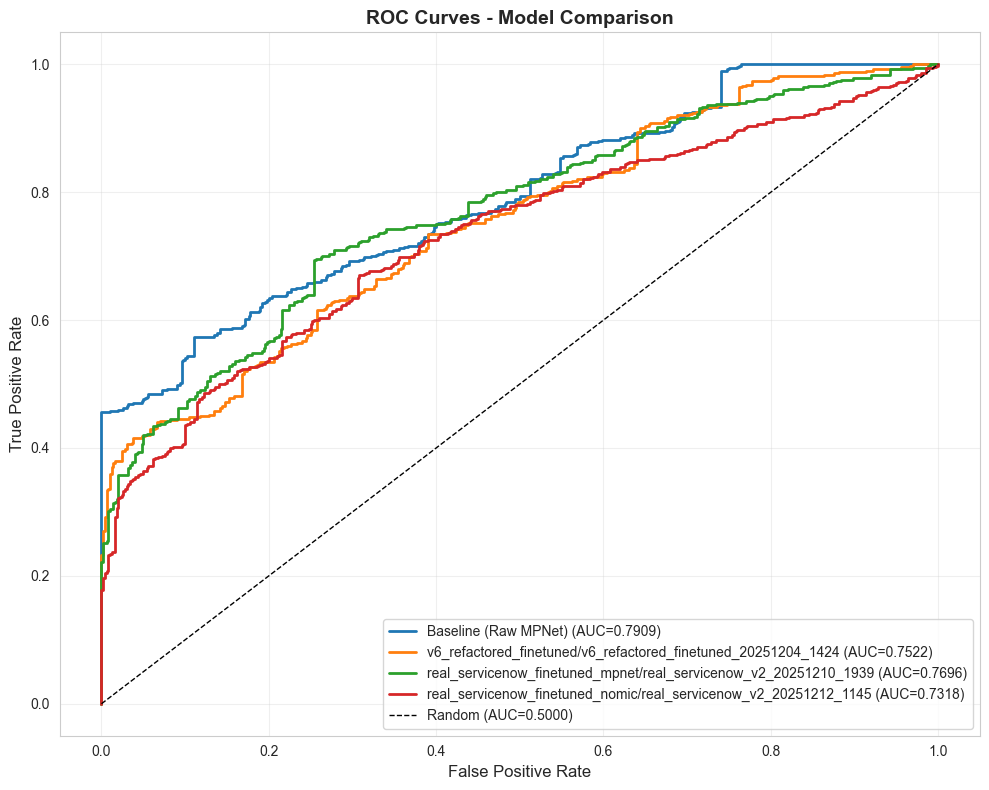

In [35]:
# Plot ROC curves
evaluator.plot_roc_curves(figsize=(10, 8))

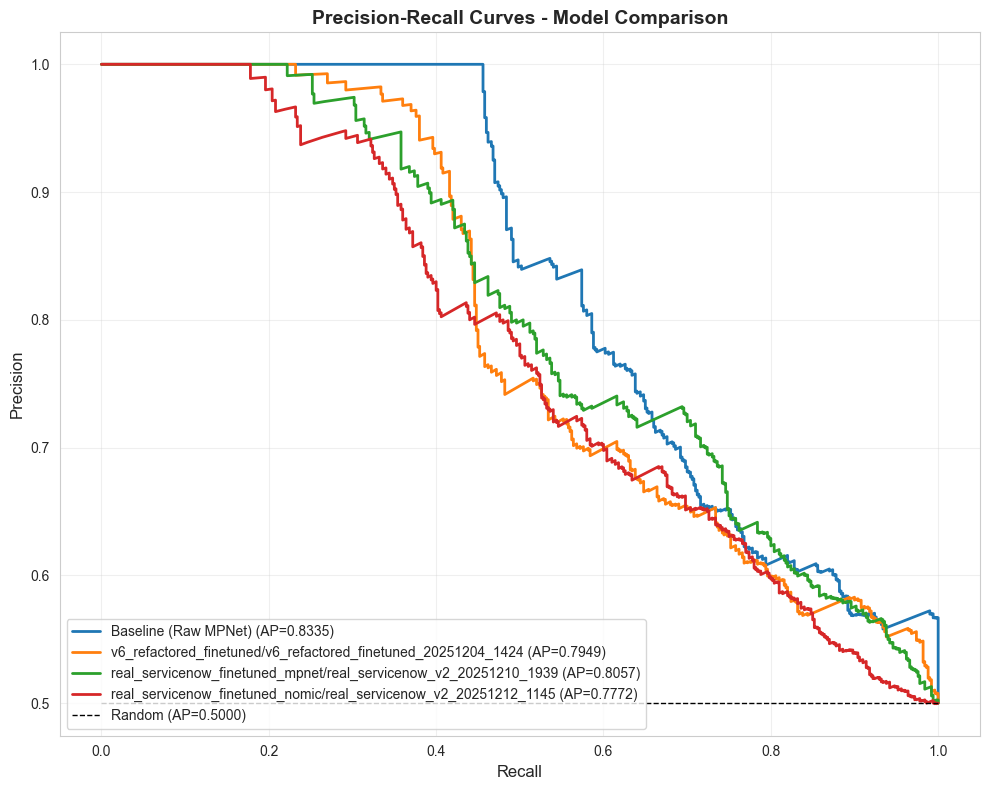

In [36]:
# Plot Precision-Recall curves
evaluator.plot_pr_curves(figsize=(10, 8))

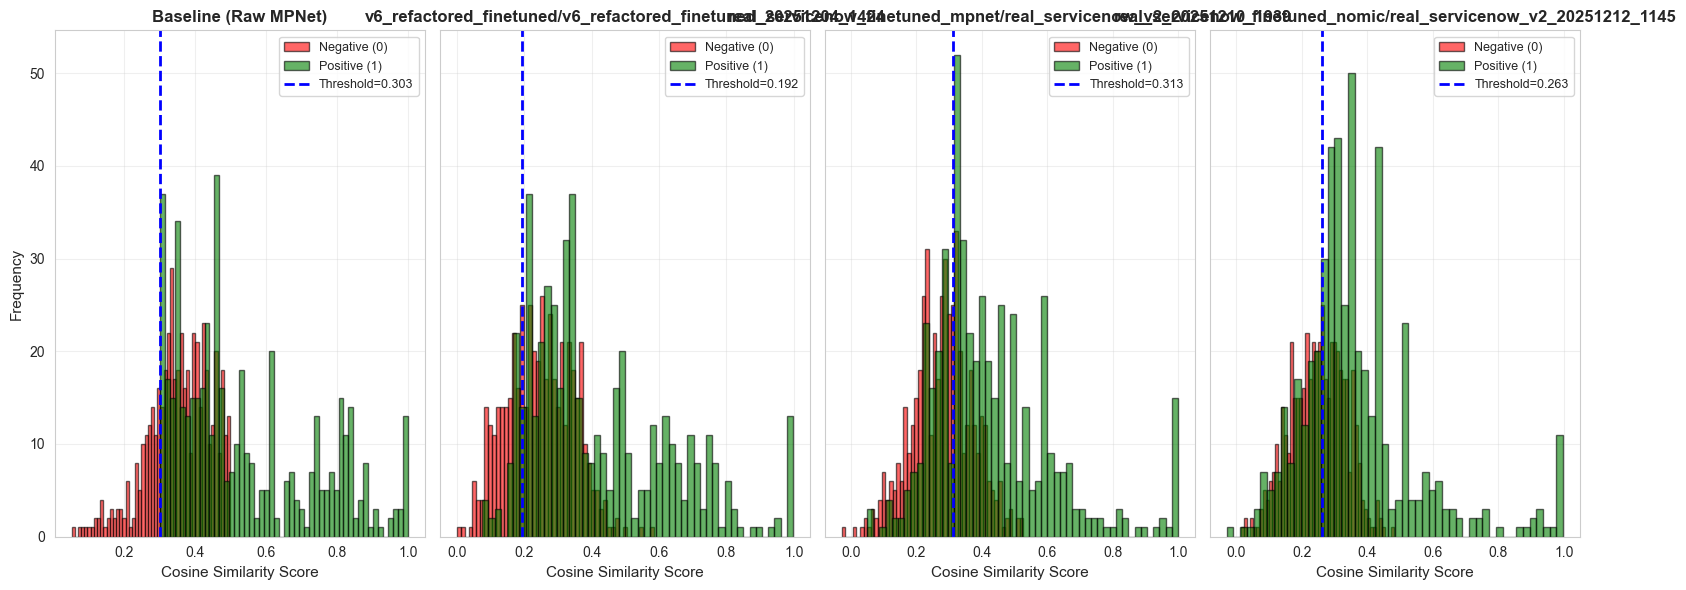

In [37]:
# Plot similarity score distributions
evaluator.plot_score_distributions(figsize=(16, 6))

## 9. Metric Analysis by Category

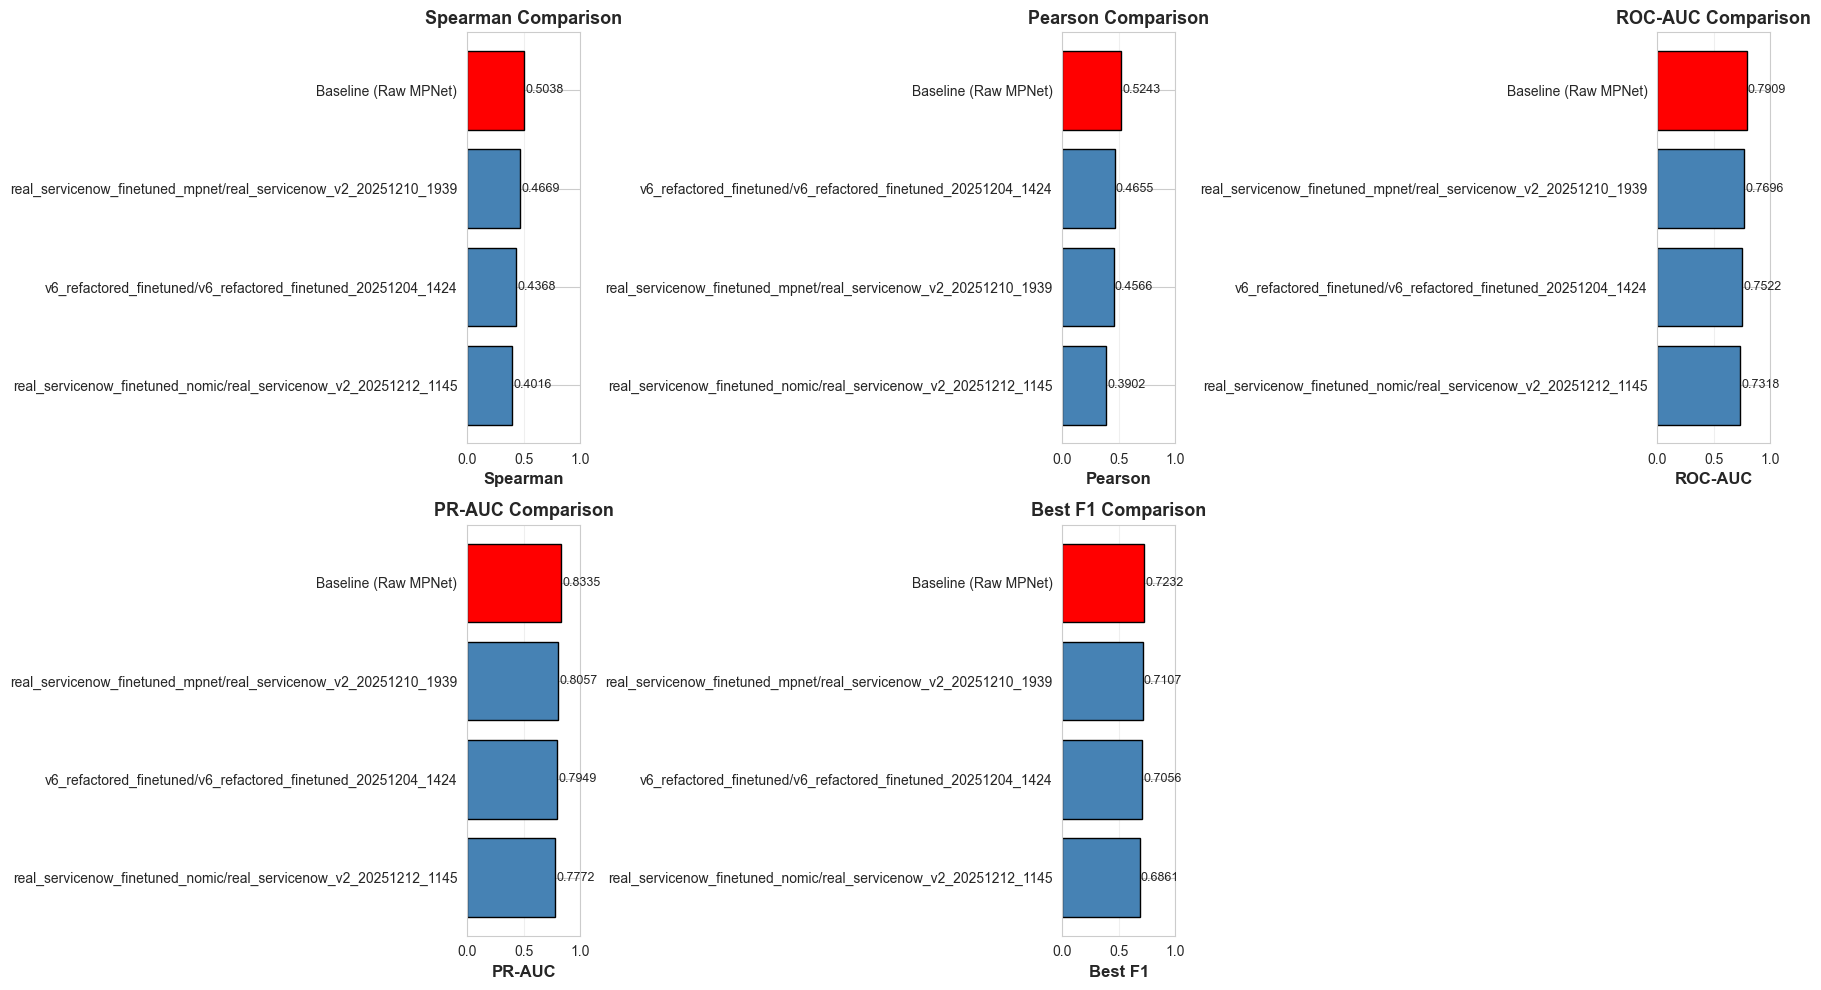

In [38]:
# Bar chart comparing key metrics across models
metrics_to_plot = ['Spearman', 'Pearson', 'ROC-AUC', 'PR-AUC', 'Best F1']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Sort by metric value
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    # Create horizontal bar chart
    colors = ['red' if model == 'Baseline (Raw MPNet)' else 'steelblue' 
              for model in sorted_df['Model']]
    
    ax.barh(sorted_df['Model'], sorted_df[metric], color=colors, edgecolor='black')
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    
    # Add value labels
    for i, (model, value) in enumerate(zip(sorted_df['Model'], sorted_df[metric])):
        if pd.notna(value):
            ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontsize=9)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

## 10. Performance Delta vs Baseline

In [39]:
# Calculate improvement over baseline
baseline_name = 'Baseline (Raw MPNet)'

if baseline_name in evaluator.results:
    baseline_metrics = {
        'Spearman': evaluator.results[baseline_name]['spearman'],
        'Pearson': evaluator.results[baseline_name]['pearson'],
        'ROC-AUC': evaluator.results[baseline_name]['roc_auc'],
        'PR-AUC': evaluator.results[baseline_name]['pr_auc'],
        'Best F1': evaluator.results[baseline_name]['best_f1']
    }
    
    improvement_data = []
    
    for model_name, results in evaluator.results.items():
        if model_name == baseline_name:
            continue
        
        improvement_data.append({
            'Model': model_name,
            'Δ Spearman': results['spearman'] - baseline_metrics['Spearman'],
            'Δ Pearson': results['pearson'] - baseline_metrics['Pearson'],
            'Δ ROC-AUC': results['roc_auc'] - baseline_metrics['ROC-AUC'] if results['roc_auc'] else None,
            'Δ PR-AUC': results['pr_auc'] - baseline_metrics['PR-AUC'] if results['pr_auc'] else None,
            'Δ F1': results['best_f1'] - baseline_metrics['Best F1'],
        })
    
    if len(improvement_data) > 0:
        improvement_df = pd.DataFrame(improvement_data)
        improvement_df = improvement_df.sort_values('Δ Spearman', ascending=False)
        
        print("\n" + "=" * 80)
        print("IMPROVEMENT OVER BASELINE (Raw MPNet)")
        print("=" * 80)
        print(improvement_df.to_string(index=False))
        print("=" * 80)
        
        # Styled version
        styled_improvement = improvement_df.style.background_gradient(
            subset=['Δ Spearman', 'Δ Pearson', 'Δ ROC-AUC', 'Δ PR-AUC', 'Δ F1'],
            cmap='RdYlGn',
            vmin=-0.1,
            vmax=0.3
        ).format({
            'Δ Spearman': '{:+.4f}',
            'Δ Pearson': '{:+.4f}',
            'Δ ROC-AUC': '{:+.4f}',
            'Δ PR-AUC': '{:+.4f}',
            'Δ F1': '{:+.4f}'
        })
        
        display(styled_improvement)
    else:
        print("\n⚠ No fine-tuned models evaluated. Only baseline model results available.")
else:
    print("Baseline model not found in results")


IMPROVEMENT OVER BASELINE (Raw MPNet)
                                                           Model  Δ Spearman  Δ Pearson  Δ ROC-AUC  Δ PR-AUC      Δ F1
real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939   -0.036852  -0.067733  -0.021276 -0.027844 -0.012428
   v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424   -0.066983  -0.058863  -0.038672 -0.038625 -0.017545
real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145   -0.102230  -0.134142  -0.059020 -0.056342 -0.037024


,Model,Δ Spearman,Δ Pearson,Δ ROC-AUC,Δ PR-AUC,Δ F1
1,real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939,-0.0369,-0.0677,-0.0213,-0.0278,-0.0124
0,v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424,-0.0670,-0.0589,-0.0387,-0.0386,-0.0175
2,real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145,-0.1022,-0.1341,-0.0590,-0.0563,-0.0370


## 11. Export Results

In [40]:
# Save comparison results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_file = RESULTS_DIR / f'model_evaluation_{timestamp}.csv'

evaluator.save_results(results_file)

# Also save improvement metrics if available
if 'improvement_df' in locals():
    improvement_file = RESULTS_DIR / f'model_improvement_{timestamp}.csv'
    improvement_df.to_csv(improvement_file, index=False)
    print(f"✓ Improvement metrics saved to: {improvement_file}")


✓ Results saved to: models/results/model_evaluation_20251217_061932.csv
✓ Improvement metrics saved to: models/results/model_improvement_20251217_061932.csv


## 12. Summary and Recommendations

In [41]:
# Generate summary report
print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)

print(f"\nTest Set Size: {len(test_labels)} pairs")
print(f"  - Positive pairs: {sum(test_labels)} ({100*sum(test_labels)/len(test_labels):.1f}%)")
print(f"  - Negative pairs: {len(test_labels) - sum(test_labels)} ({100*(len(test_labels)-sum(test_labels))/len(test_labels):.1f}%)")

print(f"\nModels Evaluated: {len(evaluator.results)}")
for model_name in evaluator.results.keys():
    print(f"  - {model_name}")

# Best model for each metric
print("\n" + "-" * 80)
print("BEST PERFORMING MODELS BY METRIC")
print("-" * 80)

for metric in ['Spearman', 'Pearson', 'ROC-AUC', 'PR-AUC', 'Best F1']:
    best_row = comparison_df.loc[comparison_df[metric].idxmax()]
    print(f"\n{metric:15s}: {best_row['Model']}")
    print(f"                 Value: {best_row[metric]:.4f}")

# Overall recommendation
print("\n" + "-" * 80)
print("RECOMMENDATION")
print("-" * 80)

# Use Spearman as primary metric (most important for ranking)
best_overall = comparison_df.loc[comparison_df['Spearman'].idxmax()]
print(f"\nBest Overall Model: {best_overall['Model']}")
print(f"  Spearman: {best_overall['Spearman']:.4f}")
print(f"  Pearson:  {best_overall['Pearson']:.4f}")
print(f"  ROC-AUC:  {best_overall['ROC-AUC']:.4f}")
print(f"  PR-AUC:   {best_overall['PR-AUC']:.4f}")

if baseline_name in evaluator.results:
    baseline_spearman = evaluator.results[baseline_name]['spearman']
    improvement_pct = 100 * (best_overall['Spearman'] - baseline_spearman) / baseline_spearman
    print(f"\nImprovement over baseline: {improvement_pct:+.1f}%")

print("\n" + "=" * 80)


EVALUATION SUMMARY

Test Set Size: 1000 pairs
  - Positive pairs: 500 (50.0%)
  - Negative pairs: 500 (50.0%)

Models Evaluated: 4
  - Baseline (Raw MPNet)
  - v6_refactored_finetuned/v6_refactored_finetuned_20251204_1424
  - real_servicenow_finetuned_mpnet/real_servicenow_v2_20251210_1939
  - real_servicenow_finetuned_nomic/real_servicenow_v2_20251212_1145

--------------------------------------------------------------------------------
BEST PERFORMING MODELS BY METRIC
--------------------------------------------------------------------------------

Spearman       : Baseline (Raw MPNet)
                 Value: 0.5038

Pearson        : Baseline (Raw MPNet)
                 Value: 0.5243

ROC-AUC        : Baseline (Raw MPNet)
                 Value: 0.7909

PR-AUC         : Baseline (Raw MPNet)
                 Value: 0.8335

Best F1        : Baseline (Raw MPNet)
                 Value: 0.7232

--------------------------------------------------------------------------------
RECOMMENDAT

## 13. Optional: Evaluate Additional Models

You can add more models to evaluate by modifying the `models_to_evaluate` list in cell 7 and re-running from there.

In [42]:
# This cell can be used to quickly evaluate a single additional model
# Uncomment and modify as needed:

# additional_model_name = 'all-mpnet-finetuned-v5'
# 
# if additional_model_name in available_models:
#     model_path = available_models[additional_model_name]
#     model = SentenceTransformer(str(model_path), device=device)
#     
#     evaluator.evaluate_model(
#         model=model,
#         model_name=additional_model_name,
#         texts1=test_texts1,
#         texts2=test_texts2,
#         labels=test_labels,
#         verbose=True
#     )
#     
#     del model
#     if device == 'cuda':
#         torch.cuda.empty_cache()
# else:
#     print(f"Model '{additional_model_name}' not found")